## ON THE INTERPRETATION OF LEARNING DYNAMICAL SYSTEMS

In [19]:
#---------------------------------------
# Load Libs
#---------------------------------------
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')

import sklearn
import sklearn.manifold
from itertools import cycle
from collections import defaultdict

In [20]:
print(plt.style.available)

['seaborn-dark-palette', 'fivethirtyeight', 'seaborn-notebook', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-dark', 'grayscale', 'seaborn-talk', 'seaborn-whitegrid', 'fast', 'seaborn-poster', 'bmh', 'seaborn-bright', 'seaborn-paper', 'seaborn-white', 'ggplot', 'tableau-colorblind10', 'seaborn-muted', 'seaborn', 'seaborn-darkgrid', '_classic_test', 'seaborn-ticks', 'seaborn-colorblind', 'seaborn-pastel', 'seaborn-deep']


In [21]:
#---------------------------------------
# Load utility functions
#---------------------------------------
import importlib
import utils 
importlib.reload(utils)
from utils import *

import helper 
importlib.reload(helper)
from helper import *

In [22]:
#---------------------------------------
# Load torch
#---------------------------------------
import torch
device = get_device()

Connected to a GPU


In [23]:
#---------------------------------------
# Set seed
#---------------------------------------
import torch.nn.init as init
np.random.seed(10)
torch.manual_seed(10)

## Example 1: The Simple Harmonic Oscillator 

In [6]:
#---------------------------------------
# Example 1: The Simple Harmonic Oscillator 
# Create Data
#---------------------------------------

t_max = 50
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)

Lambda = np.array(([0,1],[-1,0]))
#Lambda = np.array(([-0.1,1],[-1,-0.1]))
u0 = np.array(([0,1]))
data = solution_general_linear(Lambda=Lambda, u0=u0, ts=anal_ts)
data += np.random.standard_normal(data.shape) * 0.00

# send to torch
torch_data = data_to_torch(data, device)

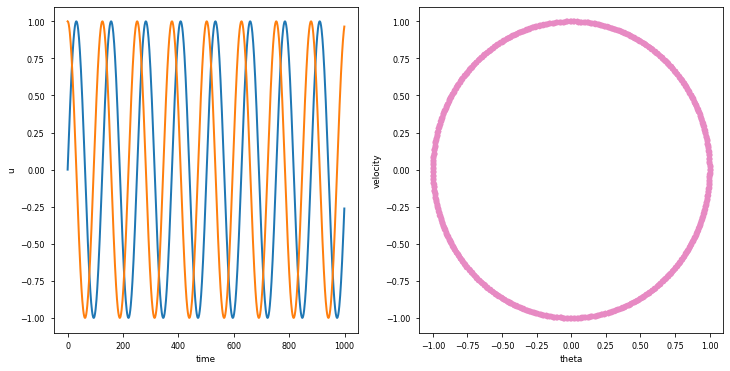

In [7]:
#
# To do: Outsource
#

#---------------------------------------
# Plot Orbit and time series
#---------------------------------------
#fig, (ax1, ax2) = plt.subplots(1, 2)
FIG_SIZE_FULL = (12,6)
def trajectory_plots(trajs):
    plt.figure(figsize=FIG_SIZE_FULL)
    plt.subplot(1,2,1)
    for data in trajs:
        plt.plot(data, lw=2)
    plt.ylabel('u')
    plt.xlabel('time')

    plt.subplot(1,2,2)
    for data in trajs:
        plt.plot(data[:,0],data[:,1], '-o', c='#e78ac3')
    plt.ylabel('velocity')
    plt.xlabel('theta')
trajectory_plots([data])

In [8]:
omega, losses, omega_trace  = learn_omega(torch_data, batch_size=25, n_future=1, device=device)

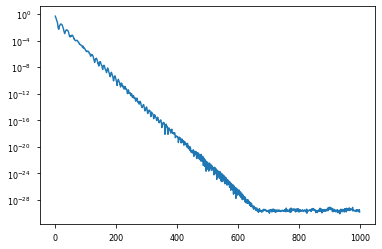

In [9]:
plt.semilogy(losses)

In [10]:
print('True Omega: \n', true_omega_linear(Lambda, dt=50/1000))
print('Lerned Omega: \n', omega.weight.data.cpu().numpy())

True Omega: 
 [[ 0.99875026  0.04997917]
 [-0.04997917  0.99875026]]
Lerned Omega: 
 [[ 0.99874776  0.05002916]
 [-0.05002916  0.99874776]]


In [11]:
omegas = []
omega_traces = []
for i in range(10):
    omega_temp, loss, omega_trace_temp = learn_omega(torch_data, batch_size=25, n_future=1, device=device)
    omegas.append( omega_temp.weight.data.cpu().numpy() )
    omega_traces.append( omega_trace_temp )

In [12]:
#omegas_exp = np.array([ np.array(OM) for oms in [experiments.values()] for OM in omega_traces ]).reshape((-1,4))
flattened_experiment_omegas = np.array([
    OM for OM in omegas
]).reshape((-1,4))
flattened_traces_omegas = np.array([
    OM for OMS in omega_traces for OM in OMS
]).reshape((-1,4))
list_of_traces_omegas = [
    np.array(OMS).reshape((-1,4)) for OMS in omega_traces ]

In [13]:
path_of_omega_alpha = np.array([one_step_factory(Lambda,dt,alpha) for alpha in np.linspace(0,1,100) ]).reshape((-1,4))

In [14]:
known_omegas = {'True':true_omega_linear(Lambda,dt)}
known_omegas.update({
    method:operator_factory(Lambda,dt,method) 
                for method in ['euler', 'bweuler', 'implicit_trap', 'midpoint','rk4'] })

In [15]:
all_omegas = np.concatenate([
    flattened_traces_omegas,
    path_of_omega_alpha,
    ] + [OM.reshape((-1,4)) for OM in known_omegas.values() ]
    )

In [16]:
#
# To do: Outsource
#


def plot_embedding(TRANSFER, experimental_omegas, path_omega, known_omegas, traces=None):
    """Embed and plot the operators, given a callback to the embedding object."""
    X_trans_alpha = TRANSFER(path_omega)
    X_trans_exps = TRANSFER(experimental_omegas)
    X_trans_known = { n:TRANSFER(omega.reshape(-1,4)) for n,omega in known_omegas.items()}
    all_points = cycle('soo****')
    markerdict = defaultdict(lambda : next(all_points))
    plt.figure(figsize=(12,7))
    # That path of the family
    plt.plot(X_trans_alpha[:,0],X_trans_alpha[:,1],'-', lw=3)
    # Known operators
    for n,X in X_trans_known.items():
        plt.plot(X[:,0],X[:,1],markerdict[n],label=n, markersize=20)
    # fix axis
    #xlim= plt.xlim()
    # The end points
    #for t in traces:
    #    X=TRANSFER(t)
    #    plt.plot(X[:,0],X[:,1],'--')
        
    gap = 0.1
    #plt.xlim((X_trans_alpha[:,0].min()-gap,X_trans_alpha[:,0].max()+gap))
    #plt.ylim((X_trans_alpha[:,1].min()-gap,X_trans_alpha[:,1].max()+gap))
    # The paths
    plt.plot(X_trans_exps[:,0],X_trans_exps[:,1],'P',label='experiments', markersize=15, c='k')
    plt.xlabel("first principal component", fontsize=22)
    plt.ylabel("second principal component", fontsize=22)
    plt.set_cmap('Set3')
    plt.tick_params(axis='x', labelsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.legend(fontsize=16)
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


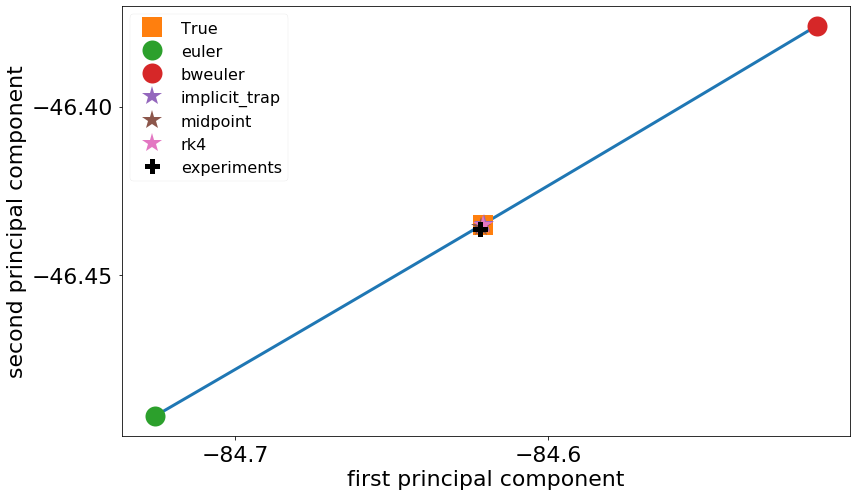

In [17]:
all_omegas_standardized = sklearn.preprocessing.scale(all_omegas, axis=0, with_mean=True, with_std=True, copy=True)
pca = sklearn.decomposition.PCA(n_components=2, svd_solver='full', whiten=True)
pca.fit(all_omegas_standardized)
plot_embedding(lambda X : pca.transform(X) / 1e-2,
              flattened_experiment_omegas,
              path_of_omega_alpha,
              known_omegas,
              list_of_traces_omegas)
plt.savefig('pca_linear_experiment' +'.eps')


## Learning the continuous companion matrix

In [34]:
all_method_combos = [
    ('FW','BW','TR'),
    ('FW','BW'),
    ('FW',),
    ('BW',),
    ('TR',)
]
results = {}
for methods in all_method_combos:
    results[methods] = learn_lambda(torch_data, batch_size=25, verbose=True, device=device, methods=methods, dt=dt)

Converged with L1:  tensor(1.5665e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
Converged with L1:  tensor(1.5661e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
Converged with L1:  tensor(3.6644e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Converged with L1:  tensor(3.1088e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Converged with L1:  tensor(2.0660e-30, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)


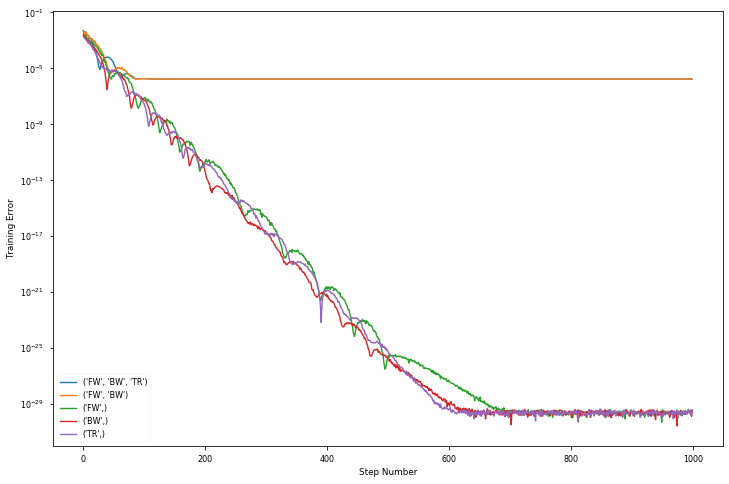

In [35]:
plt.rcParams.update({'font.size':18})
plt.figure(figsize=(12,8))
for k,(model,loss,mat,tr,fw,bw) in results.items():
    plt.semilogy(loss,label=k)
plt.ylabel('Training Error')
plt.xlabel('Step Number')
plt.legend()
plt.show()

In [36]:
print("Name & Lambda & FW Euler & BW Euler & Trap \\\\")
for k, (model,loss,mat,tr,fw,bw) in results.items():
    lm = mat #.weights.detach().cpu().numpy()
    #print(fw, bw, tr)
    fw_op_err = np.linalg.norm( fw - Lambda) / np.linalg.norm(Lambda)
    bw_op_err = np.linalg.norm( bw - Lambda) / np.linalg.norm(Lambda)
    tr_op_err = np.linalg.norm( tr - Lambda) / np.linalg.norm(Lambda)
    lm_err = np.linalg.norm( lm - Lambda ) / np.linalg.norm(Lambda)
    print( f"{str(k):<18} & {lm_err:1.4e} & {fw_op_err:1.4e} & {bw_op_err:1.4e} & {tr_op_err:1.4e} \\\\")

Name & Lambda & FW Euler & BW Euler & Trap \\
('FW', 'BW', 'TR') & 7.9433e-04 & 1.3793e+00 & 1.3776e+00 & 1.3784e+00 \\
('FW', 'BW')       & 5.8896e-04 & 1.3793e+00 & 1.3776e+00 & 1.3784e+00 \\
('FW',)            & 2.5052e-02 & 1.3784e+00 & 1.3768e+00 & 1.3775e+00 \\
('BW',)            & 2.5052e-02 & 1.3802e+00 & 1.3784e+00 & 1.3793e+00 \\
('TR',)            & 1.2100e-03 & 1.3793e+00 & 1.3775e+00 & 1.3784e+00 \\


In [37]:
fw_op_err

1.3792697533226148

In [38]:
for  k,(model,loss,mat,tr,fw,bw) in results.items():
    print(k)
    print(mat)
    print(mat-Lambda)

('FW', 'BW', 'TR')
[[-4.38675657e-05  1.00079933e+00]
 [-1.00078786e+00 -1.88263749e-05]]
[[-4.38675657e-05  7.99326398e-04]
 [-7.87863374e-04 -1.88263749e-05]]
('FW', 'BW')
[[-3.80861682e-05  1.00055598e+00]
 [-1.00061609e+00 -6.00771381e-05]]
[[-3.80861682e-05  5.55983542e-04]
 [-6.16086211e-04 -6.00771381e-05]]
('FW',)
[[-0.02504485  1.00058313]
 [-1.00058313 -0.02504485]]
[[-0.02504485  0.00058313]
 [-0.00058313 -0.02504485]]
('BW',)
[[ 0.02504485  1.00058313]
 [-1.00058313  0.02504485]]
[[ 0.02504485  0.00058313]
 [-0.00058313  0.02504485]]
('TR',)
[[ 2.06174334e-15  1.00121001e+00]
 [-1.00121001e+00  1.67243768e-16]]
[[ 2.06174334e-15  1.21001294e-03]
 [-1.21001294e-03  1.67243768e-16]]


## Example 2: The Damped Harmonic Oscillator 